# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [2]:
# Do all imports and installs here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Indicate what kind of the immigration data you want to load.
# sample_data or original_data
file_type = 'sample'

In [2]:
from utils import PostgreSQL, Configuration

db_conn_info = {
    'dbname': Configuration.get_value('database', 'DB_NAME'),
    'host': Configuration.get_value('database', 'HOST'),
    'port': Configuration.get_value('database', 'PORT'),
    'user': Configuration.get_value('database', 'USER'),
    'password': Configuration.get_value('database', 'PASSWORD'),
}

db = PostgreSQL(**db_conn_info)

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

 - **I94 Immigration Data**: This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. This is where the data comes from. There's a sample file so you can take a look at the data in csv format before reading it all in. You do not have to use the entire dataset, just use what you need to accomplish the goal you set at the beginning of the project.
 
 - **U.S. City Demographic Data**: This data comes from OpenSoft. You can read more about it here

In [3]:
# Read I94 Immigration dataset
if file_type == 'sample_data':
    file_path = './dataset/immigration_data_sample.csv'
    immigration_df = pd.read_csv(file_path, index_col=0)
    immigration_df.head()
elif file_type == 'original_data':
    file_path = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
    immigration_df = pd.read_sas(file_path)
else:
    print('Unknow file_type: {}'.format(file_type))

In [5]:
# U.S City demograpgic data
demographics_df = pd.read_csv('./dataset/us-cities-demographics.csv', delimiter=';')
demographics_df.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [ ]:
# This is for read whole I94 Immigration dataset, and process by pyspark module
# But we don't use it on this project.
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [ ]:
#write to parquet
df_spark.write.parquet("sas_data")
df_spark=spark.read.parquet("sas_data")

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

#### Immigration Data

In [6]:
# Get all column names
immigration_df.columns

Index(['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate',
       'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count',
       'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu',
       'matflag', 'biryear', 'dtaddto', 'gender', 'insnum', 'airline',
       'admnum', 'fltno', 'visatype'],
      dtype='object')

### Explore and Process Fact_immigration data

   1. Select columns which are used by fact_immigration 
   2. Change column names
   3. Check missing values of all columns
   4. Convert float columns to integer
   5. Process missing value of gender field
   6. Convert SAS date format to datetime format
   7. Visualize exploring results 

In [7]:
# Define which columns are used by fact_immigration, and their new column names.
fact_immigration_cols = [
    'cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res',
    'i94port', 'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94visa',
    'biryear', 'gender',  'visatype'
]
new_fact_immigration_colnames = [
    'cic_id', 'year', 'month', 'citizen_of_country', 'resident_of_country',
    'port_code', 'arrival_date', 'mode_id', 'state_code', 'departure_date', 'visa_category_id',
    'birth_year', 'gender', 'visa_type' 
]

In [8]:
# Get fact_immigration
fact_immigration_df = immigration_df.loc[:, fact_immigration_cols]
fact_immigration_df.columns = new_fact_immigration_colnames
fact_immigration_df.head()

,cic_id,year,month,citizen_of_country,resident_of_country,port_code,arrival_date,mode_id,state_code,departure_date,visa_category_id,birth_year,gender,visa_type
2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,2.0,1955.0,F,WT
2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,2.0,1990.0,M,B2
589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,2.0,1940.0,M,WT
2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,2.0,1991.0,M,B2
3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,2.0,1997.0,F,WT


In [9]:
# Check missing value
fact_immigration_df.isna().sum()

cic_id                   0
year                     0
month                    0
citizen_of_country       0
resident_of_country      0
port_code                0
arrival_date             0
mode_id                  0
state_code              59
departure_date          49
visa_category_id         0
birth_year               0
gender                 141
visa_type                0
dtype: int64

In [10]:
# Drop data when state_code is missing value
fact_immigration_df = fact_immigration_df[fact_immigration_df['state_code'].notna()]
fact_immigration_df.isna().sum()

cic_id                   0
year                     0
month                    0
citizen_of_country       0
resident_of_country      0
port_code                0
arrival_date             0
mode_id                  0
state_code               0
departure_date          42
visa_category_id         0
birth_year               0
gender                 127
visa_type                0
dtype: int64

In [10]:
# Convert data type from float to integer
convert_int_cols = [
    'cic_id', 'year', 'month', 'citizen_of_country', 'resident_of_country',
    'arrival_date', 'mode_id', 'departure_date', 'visa_category_id', 'birth_year',
]
fact_immigration_df.loc[:, convert_int_cols] = fact_immigration_df.loc[:, convert_int_cols].apply(
    lambda _float_num: pd.to_numeric(_float_num, errors='ignore', downcast='integer')
)

In [11]:
# Get what kind of values in gender
print(fact_immigration_df.gender.unique())

# Replace 'X' and nan to 'Unknown'
fact_immigration_df.loc[:, 'gender'].replace({'X': 'Unknown', np.nan:'Unknown'}, inplace=True)

print('-'*10 + ' After replacing values ' + '-'*10)
fact_immigration_df.gender.unique()

['F' 'M' nan]
---------- After replacing values ----------


array(['F', 'M', 'Unknown'], dtype=object)

### Convert SAS date to datetime
#### According to [this link](https://v8doc.sas.com/sashtml/lrcon/zenid-63.htm)
> [A] SAS date value is a value that represents the number of days between January 1, 1960, and a specified date

In [12]:
convert_sas_date = lambda days: pd.to_timedelta(days, unit='D', errors='ignore') + pd.Timestamp('1960-1-1')

convert_date_cols = ['arrival_date', 'departure_date']
fact_immigration_df.loc[:, convert_date_cols] = fact_immigration_df.loc[:, convert_date_cols].apply(convert_sas_date)

In [13]:
# Write data to database

for _, row in fact_immigration_df.iterrows():
    insert_dict = row.dropna().to_dict()
    db.insert_by_dict('fact_immigration', insert_dict, True, ['cic_id'])

### Visualize exploring result

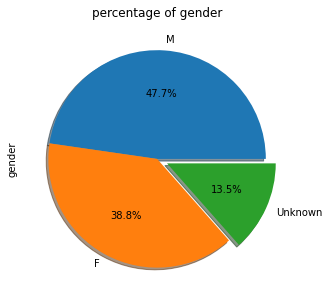

In [14]:
fact_immigration_df.gender.value_counts().plot(
    kind='pie', rotatelabels=0, autopct='%1.1f%%',
    shadow=True, startangle=0, explode=(0, 0, 0.1),
    title='percentage of gender', figsize=(5, 5)
)
plt.show()

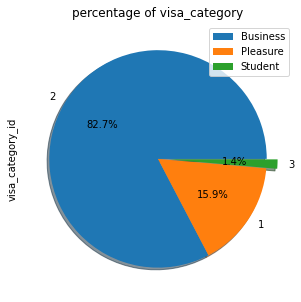

In [15]:
fact_immigration_df['visa_category_id'].value_counts().plot(
    kind='pie', rotatelabels=0, autopct='%1.1f%%',
    shadow=True, startangle=0, explode=(0, 0, 0.1),
    title='percentage of visa_category', figsize=(5, 5)
)
plt.legend({'Business': 1, 'Pleasure': 2, 'Student': 3})
plt.show()

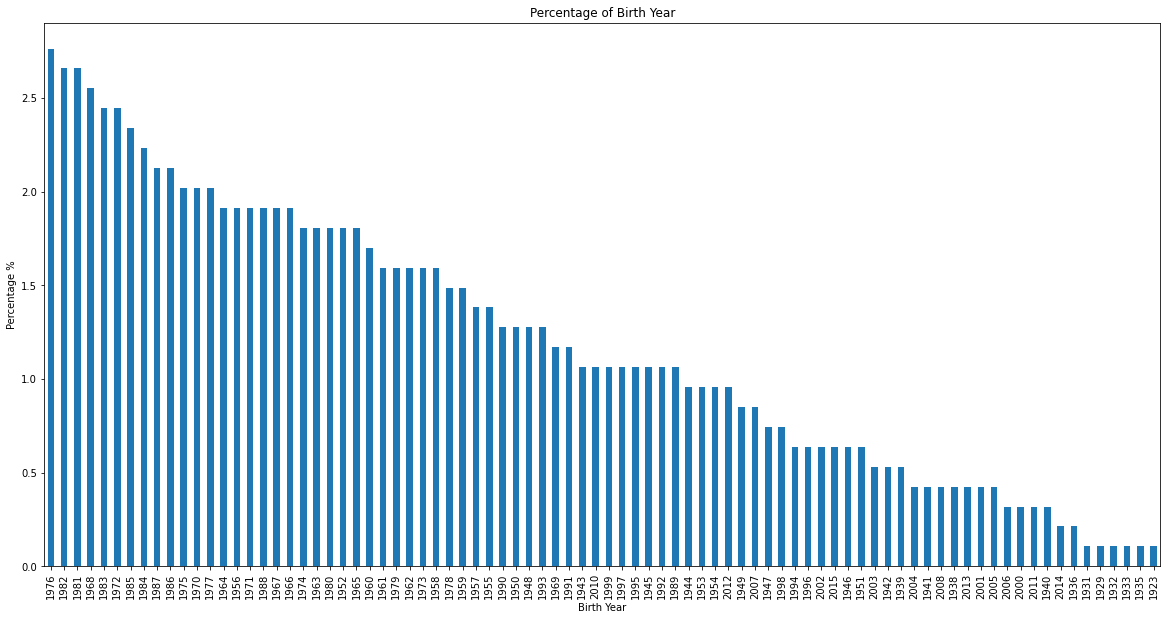

In [16]:
percentage_of_birth_year = (fact_immigration_df.birth_year.value_counts()/fact_immigration_df.shape[0]) * 100
percentage_of_birth_year.plot(kind='bar', figsize=(20, 10))
plt.title('Percentage of Birth Year')
plt.xlabel('Birth Year')
plt.ylabel('Percentage %')
plt.show()

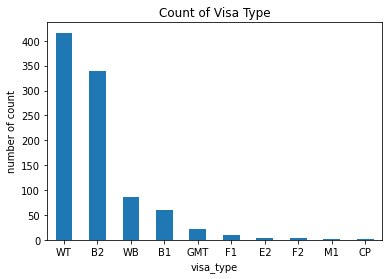

In [17]:
fact_immigration_df['visa_type'].value_counts().plot(kind='bar', rot=0)
plt.title('Count of Visa Type')
plt.xlabel('visa_type')
plt.ylabel('number of count')
plt.show()

### Explore and Process dim_airline data

   1. Select columns which are used by dim_airline
   2. Change column names
   3. Check missing values of all columns
   4. Visualize. exploring results

In [18]:
# Define which columns are used by airline, and their new column names
dim_airlin_cols = ['cicid', 'airline', 'admnum', 'fltno']
new_dim_airline_colnames = [
    'cic_id', 'airline', 'admission_num', 'flight_num',
]

# Get dim_airline
dim_airline = immigration_df.loc[:, dim_airlin_cols]
dim_airline.columns = new_dim_airline_colnames

In [19]:
# Check missing values
# Due to the different mode, the airline may have missing values,
# and we should drop it
dim_airline.isna().sum()

cic_id            0
airline          33
admission_num     0
flight_num        8
dtype: int64

In [20]:
dim_airline = dim_airline[dim_airline['airline'].notna()]
dim_airline.isna().sum()

cic_id           0
airline          0
admission_num    0
flight_num       1
dtype: int64

In [21]:
dim_airline.admission_num.astype(np.int64, copy=False)
dim_airline.head()

,cic_id,airline,admission_num,flight_num
2027561,4084316.0,JL,5.658267e+10,00782
2171295,4422636.0,*GA,9.436200e+10,XBLNG
589494,1195600.0,LH,5.578047e+10,00464
2631158,5291768.0,QR,9.478970e+10,00739
721257,1481650.0,DL,7.368526e+08,910


In [22]:
# Write to database
for _, row in dim_airline.iterrows():
    insert_dict = row.dropna().to_dict()
    db.insert_by_dict('dim_airline', insert_dict, True, ['cic_id'])

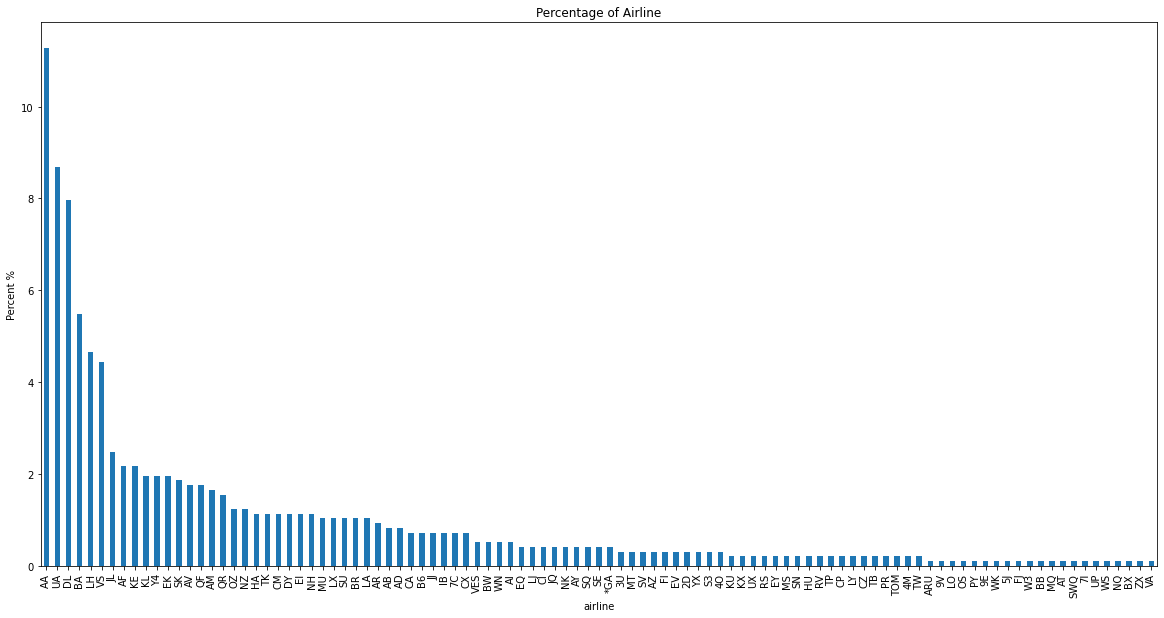

In [23]:
percentage_airline = (dim_airline.airline.value_counts()/dim_airline.shape[0]) * 100
percentage_airline.plot(kind='bar', figsize=(20, 10))
plt.title('Percentage of Airline')
plt.xlabel('airline')
plt.ylabel('Percent %')
plt.show()

### Explore and Porcess demographics data

In [24]:
demographics_df.columns

Index(['City', 'State', 'Median Age', 'Male Population', 'Female Population',
       'Total Population', 'Number of Veterans', 'Foreign-born',
       'Average Household Size', 'State Code', 'Race', 'Count'],
      dtype='object')

In [25]:
new_demographics_colnames = [
    'city', 'state', 'median_age', 'male_population', 'female_population',
    'total_population', 'number_of_veterans', 'foreign_born',
    'average_household_size', 'state_code', 'race', 'number_of_household'
]
demographics_df.columns = new_demographics_colnames

In [26]:
demographics_df.isna().sum()

city                       0
state                      0
median_age                 0
male_population            3
female_population          3
total_population           0
number_of_veterans        13
foreign_born              13
average_household_size    16
state_code                 0
race                       0
number_of_household        0
dtype: int64

In [27]:
# There are 49 different states in this data.
print(demographics_df.state_code.unique())

# California has the most cities.
demographics_df[['city', 'state']].groupby(by=['state']).count().sort_values(by='city', ascending=False)

['MD' 'MA' 'AL' 'CA' 'NJ' 'IL' 'AZ' 'MO' 'NC' 'PA' 'KS' 'FL' 'TX' 'VA'
 'NV' 'CO' 'MI' 'CT' 'MN' 'UT' 'AR' 'TN' 'OK' 'WA' 'NY' 'GA' 'NE' 'KY'
 'SC' 'LA' 'NM' 'IA' 'RI' 'PR' 'DC' 'WI' 'OR' 'NH' 'ND' 'DE' 'OH' 'ID'
 'IN' 'AK' 'MS' 'HI' 'SD' 'ME' 'MT']


,city
state,
California,676
Texas,273
Florida,222
Illinois,91
Washington,85
Arizona,80
Colorado,80
Michigan,79
Virginia,70


In [28]:
# The Villages in Florilda doesn't have male_population, female_population and avergae_household_size data
demographics_df.loc[demographics_df['male_population'].isna(), :]

,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,race,number_of_household
333,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,Hispanic or Latino,1066
449,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,Black or African-American,331
1437,The Villages,Florida,70.5,NaN,NaN,72590,15231.0,4034.0,NaN,FL,White,72211


In [29]:
# Puerto Rico doesn't have number_of_veterans, foreign_born and average_household_size data
demographics_df.loc[demographics_df['number_of_veterans'].isna(), :]

,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,race,number_of_household
111,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,Hispanic or Latino,335559
155,Caguas,Puerto Rico,40.4,34743.0,42265.0,77008,NaN,NaN,NaN,PR,Hispanic or Latino,76349
258,Carolina,Puerto Rico,42.0,64758.0,77308.0,142066,NaN,NaN,NaN,PR,American Indian and Alaska Native,12143
637,Carolina,Puerto Rico,42.0,64758.0,77308.0,142066,NaN,NaN,NaN,PR,Hispanic or Latino,139967
1747,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,American Indian and Alaska Native,4031
1748,Mayagüez,Puerto Rico,38.1,30799.0,35782.0,66581,NaN,NaN,NaN,PR,Asian,235
1995,Ponce,Puerto Rico,40.5,56968.0,64615.0,121583,NaN,NaN,NaN,PR,Hispanic or Latino,120705
2004,Bayamón,Puerto Rico,39.4,80128.0,90131.0,170259,NaN,NaN,NaN,PR,Hispanic or Latino,169155
2441,San Juan,Puerto Rico,41.4,155408.0,186829.0,342237,NaN,NaN,NaN,PR,Asian,2452
2589,Guaynabo,Puerto Rico,42.2,33066.0,37426.0,70492,NaN,NaN,NaN,PR,Hispanic or Latino,69936


In [30]:
demographics_df['percentage_of_male'] = demographics_df['male_population'] / demographics_df['total_population']
demographics_df['percentage_of_female'] = demographics_df['female_population'] / demographics_df['total_population']
# demographics_df = demographics_df.round({'percentage_of_male': 3, 'percentage_of_female': 3})
demographics_df.head()

,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,race,number_of_household,percentage_of_male,percentage_of_female
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924,0.492,0.508
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723,0.471,0.529
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759,0.448,0.552
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437,0.503,0.497
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402,0.490,0.510


In [31]:
# Each State average values
cols = [
    'median_age', 'male_population', 'female_population', 
    'total_population', 'number_of_veterans', 'foreign_born',
    'average_household_size', 'number_of_household', 'state', 'percentage_of_male',
    'percentage_of_female'
]

state_demographics = demographics_df.loc[:, cols].groupby(['state']).mean().round(3)
state_demographics.head()

,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,number_of_household,percentage_of_male,percentage_of_female
state,,,,,,,,,,
Alabama,36.162,72005.882,79856.059,151861.941,10379.294,7427.676,2.430,32239.824,0.473,0.527
Alaska,32.200,152945.000,145750.000,298695.000,27492.000,33258.000,2.770,67245.600,0.512,0.488
Arizona,35.038,139215.938,142005.438,281221.375,16531.562,42644.562,2.774,71936.012,0.488,0.512
Arkansas,32.738,48300.828,51109.138,99409.966,5323.793,10612.172,2.527,22193.000,0.484,0.516
California,36.174,90319.041,92290.948,182609.990,6829.914,54821.985,3.095,46972.956,0.493,0.507


In [32]:
# Check which state has the highest value
check_colnames = [
    'median_age', 'total_population', 'number_of_veterans',
    'foreign_born', 'average_household_size', 'number_of_household','percentage_of_male',
    'percentage_of_female'
]

for colname in check_colnames:
    state_name = state_demographics.sort_values(by=[colname], ascending=False).index[0]
    print('{} has the highest {}'.format(state_name, colname))

Hawaii has the highest median_age
New York has the highest total_population
Kentucky has the highest number_of_veterans
New York has the highest foreign_born
Utah has the highest average_household_size
New York has the highest number_of_household
Alaska has the highest percentage_of_male
Delaware has the highest percentage_of_female


In [34]:
# Write to database
for _, row in demographics_df.iterrows():
    insert_dict = row.dropna().to_dict()
    db.insert_by_dict('dim_demographics', insert_dict, True, ['city', 'state_code'])

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [ ]:
# Write code here

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Perform quality checks here

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.